In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import joblib
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost

np.random.seed(26)
sns.set_theme(style="whitegrid")

Import MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

In [ ]:
# Fetch the dataset and print description
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

EDA:

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
mnist.data.min(), mnist.data.max()

(np.int64(0), np.int64(255))

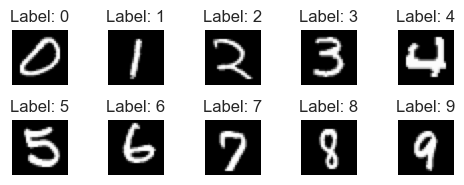

In [12]:
# Display a grid of a random sample image for each digit
images = mnist["data"]
labels = mnist["target"].astype(np.uint8)

def sample_images(images, labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(5, 2))

    for i, label in enumerate(unique_labels):
        # Find all indices of the current label
        indices = np.where(labels == label)[0]
        # Show a random index each time
        random_index = random.choice(indices)

        plt.subplot(2, 5, i + 1)
        # Reshape image to 28x28 and display in grayscale
        image = images[random_index].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_images(images, labels)

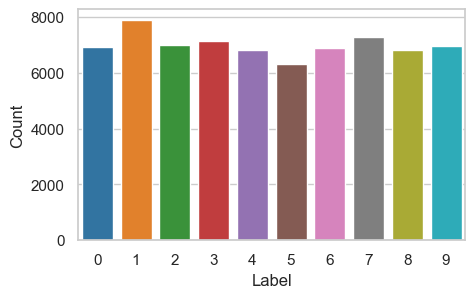

In [13]:
plt.figure(figsize=(5, 3))
sns.barplot(x=np.unique(labels), y=np.bincount(labels), hue=np.unique(labels), palette="tab10", legend=False)
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Preprocess and split data into training, validation, and test datasets:

In [14]:
X = mnist.data
y = mnist.target.astype(np.uint8)

# Flatten the images
X = X.reshape(X.shape[0], 784)

# Normalize pixel values
X = X.astype('float32') / 255.0

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=26)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=26)

In [15]:
X_train.shape, X_val.shape, X_test.shape

((56700, 784), (6300, 784), (7000, 784))

Models:

In [16]:
rfc = RandomForestClassifier(n_estimators=100, random_state=26)
etc = ExtraTreesClassifier(n_estimators=100, random_state=26)
xgb = xgboost.XGBClassifier(random_state=26)


In [ ]:
# Random forest classifier
rfc.fit(X_train, y_train)

In [18]:
y_pred_rfc = rfc.predict(X_val)
accuracy_rfc = accuracy_score(y_val, y_pred_rfc)
print(f"Random Forest Classifier accuracy: {accuracy_rfc:.4f}")

Random Forest Classifier accuracy: 0.9657


In [ ]:
# Extra trees classifier
etc.fit(X_train, y_train)

In [20]:
y_pred_etc = etc.predict(X_val)
accuracy_etc = accuracy_score(y_val, y_pred_etc)
print(f"Extra Trees Classifier accuracy: {accuracy_etc:.4f}")

Extra Trees Classifier accuracy: 0.9671


In [ ]:
# XGBoost classifier
xgb.fit(X_train, y_train)

Saving cell output as markdown because otherwise it crashes the jupyter notebook preview on Github

```XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None,     interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None,               num_parallel_tree=None, objective='multi:softprob', ...)```

In [22]:
y_pred_xgb = xgb.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"XGBoost Classifier accuracy: {accuracy_xgb:.4f}")

XGBoost Classifier accuracy: 0.9743


Since the XGBoost model has perormed best out of the three, choosing it as the final model.

In [ ]:
# Find the best parameters for the XGBoost model
model = xgboost.XGBClassifier(objective='multi:softmax', num_class=10, random_state=26, device='cuda', 
                              early_stopping_rounds=10, eval_metric='mlogloss', n_estimators=3000)

params = {    
    'learning_rate': np.arange(0.01, 0.10, 0.01),
    'max_depth': np.arange(3, 7),    
    'subsample': np.arange(0.7, 1.0, 0.05),
    'colsample_bytree': np.arange(0.7, 1.0, 0.05)
    }

search = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=30,
    cv=3,
    random_state=26,
    refit=True,
    verbose=2)

search.fit(X_train, y_train, eval_set=[(X_val, y_val)])

In [ ]:
# List the best parameters for the final model found using RandomizedSearchCV
print("Best Parameters:", search.best_params_)

In [3]:
best_params = {'subsample': np.float64(0.75), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.060000000000000005), 'colsample_bytree': np.float64(0.9000000000000001)}

df = pd.DataFrame(list(best_params.items()), columns=['Parameter', 'Value'])
print(df)

          Parameter  Value
0         subsample   0.75
1         max_depth   5.00
2     learning_rate   0.06
3  colsample_bytree   0.90


In [27]:
print("Best Score:", search.best_score_)

Best Score: 0.9758024691358025


In [28]:
print("Best Estimator:", search.best_estimator_)

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9000000000000001), device='cuda',
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.060000000000000005), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(5), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)


In [29]:
# Retrain the best model on the full training set
best_model = search.best_estimator_
best_model.set_params(early_stopping_rounds=None, device='cpu')
final_model = best_model.fit(X_train_full, y_train_full)

In [30]:
# Save model with joblib
joblib.dump(final_model, "models/model.joblib")

['models/model.joblib']

In [2]:
final_model = joblib.load("models/model.joblib")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

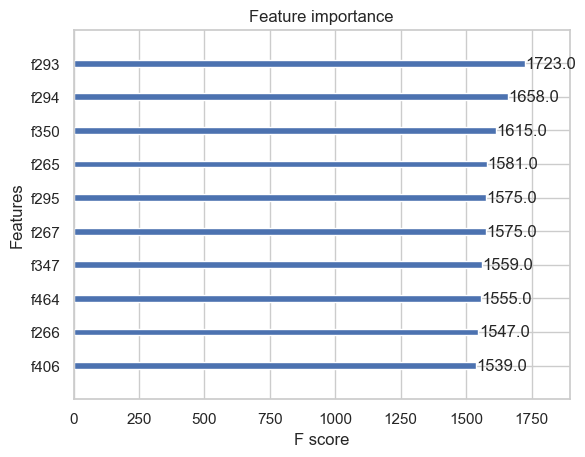

In [ ]:
# XGBoost feature importance
xgboost.plot_importance(final_model, importance_type='weight', max_num_features=10)

In [31]:
# Test the final model on the test set
y_pred_final = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final model accuracy: {accuracy:.4f}")

Final model accuracy: 0.9810


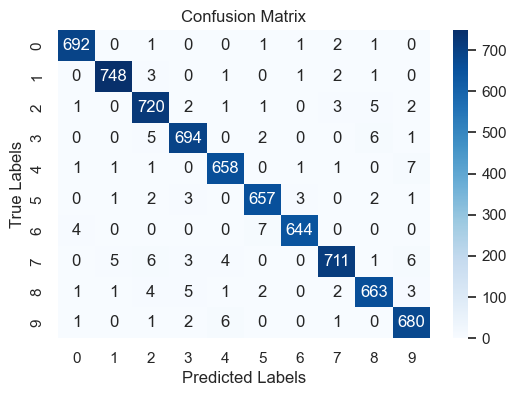

In [32]:
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
report = classification_report(y_test, y_pred_final)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       698
           1       0.99      0.99      0.99       756
           2       0.97      0.98      0.97       735
           3       0.98      0.98      0.98       708
           4       0.98      0.98      0.98       670
           5       0.98      0.98      0.98       669
           6       0.99      0.98      0.99       655
           7       0.98      0.97      0.98       736
           8       0.98      0.97      0.97       682
           9       0.97      0.98      0.98       691

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000

